In [134]:
#!pip install jovian --upgrade --quiet

In [135]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import os
%matplotlib inline

In [136]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [137]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [138]:
#project name
project_name = 'natural-scene-classification'

In [139]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [140]:
data_dir = "/content/gdrive/MyDrive/ml/seg_train/seg_train/"
test_data_dir = "/content/gdrive/MyDrive/ml/seg_test/seg_test"

In [141]:
import os
os.listdir("/content/gdrive/MyDrive/ml/") # returns list

['archive.zip', 'seg_pred', 'seg_test', 'seg_train']

In [142]:
#import zipfile
#with zipfile.ZipFile('/content/gdrive/MyDrive/ml/archive.zip', 'r') as zip_ref:
#    zip_ref.extractall('/content/gdrive/MyDrive/ml/')

In [143]:
os.listdir("/content/gdrive/MyDrive/ml/") # returns list

['archive.zip', 'seg_pred', 'seg_test', 'seg_train']

In [144]:
building_files = os.listdir(data_dir + '/buildings')
print(f"Number of Buildings : {len(building_files)}")
print(building_files[:5])

Number of Buildings : 2191
['19456.jpg', '19460.jpg', '19466.jpg', '19513.jpg', '19526.jpg']


In [145]:
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [146]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [147]:
print(f"Images in training data : {len(dataset)}")
print(f"Images in test data : {len(test_dataset)}")

Images in training data : 14034
Images in test data : 3000


In [148]:
print("Follwing classes are there : \n",dataset.classes)

Follwing classes are there : 
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [149]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

Label : buildings


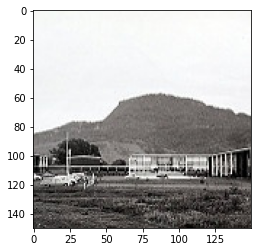

In [150]:
display_img(*dataset[0])

Label : glacier


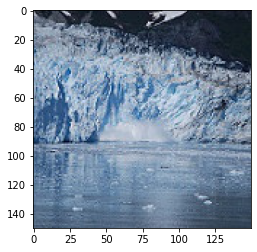

In [151]:
display_img(*dataset[5000])

Label : mountain


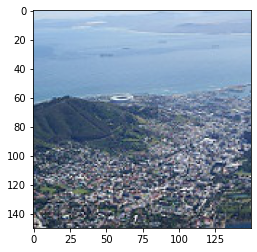

In [152]:
display_img(*dataset[8000])

In [153]:
random_seed = 2021
torch.manual_seed(random_seed)

In [154]:
val_size = 2000
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 12034
Length of Validation Data : 2000


In [155]:
batch_size = 64

In [156]:
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 2, pin_memory = True)

In [157]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

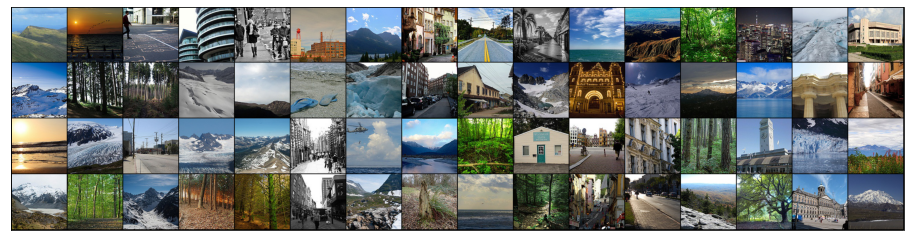

In [158]:
show_batch(train_dl)

In [159]:
class PrintSize(nn.Module):
  def __init__(self,prefix):
    super(PrintSize, self).__init__()
    self._prefix = prefix
    
  def forward(self, x):
    # comment in to see the size of each tensor at each stage of the CNN
    #print("{}: {}".format(self._prefix,x.shape))
    return x

In [160]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [161]:
class NaturalSceneClassification(ImageClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        self.network = nn.Sequential(
            # image size is 150 x 150 x 3
            # input channel size is 3 (from above)
            # output channel size is 32
            # kernel/filter size is 3 x 3
            # padding is 1
            # output size is n+2p-f/s + 1
            # nh_out = ((150 + 2 - 3)/1) + 1 = 150
            # nw_out = 150
            # nc_l = 32
            # so out should be of size 150 x 150 x 32
            PrintSize("begin"), 
            #begin: torch.Size([32, 3, 150, 150])
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            PrintSize("conv2d_1"),
            #conv2d_1: torch.Size([32, 32, 150, 150])
            nn.ReLU(),
            PrintSize("Relu_1"),
            #Relu_1: torch.Size([32, 32, 150, 150])
            # n+2p-f/s + 1
            #nh_out = ((150 + 2 - 3)/1) + 1 = 150
            #nc_l-1 = 32
            #nc_l   = 64
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            PrintSize("conv2d_2"),
            #conv2d_2: torch.Size([32, 64, 150, 150])
            nn.ReLU(),
            PrintSize("Relu_2"),
            #Relu_2: torch.Size([32, 64, 150, 150])
            #kernel_size = 2, stride = 2
            # use same formula for maxpool output dimensions
            # n+2p-f/s + 1
            # n_h = ((150 + 0 - 2)/2) + 1 = 75
            nn.MaxPool2d(2,2),
            PrintSize("maxpool_1"),
            #maxpool_1: torch.Size([32, 64, 75, 75])
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            PrintSize("conv2d_3"),
            #conv2d_3: torch.Size([32, 128, 75, 75])
            nn.ReLU(),
            PrintSize("Relu_3"),
            #Relu_3: torch.Size([32, 128, 75, 75])
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            PrintSize("conv2d_4"),
            #conv2d_4: torch.Size([32, 128, 75, 75])
            nn.ReLU(),
            PrintSize("Relu_4"),
            #Relu_4: torch.Size([32, 128, 75, 75])
            nn.MaxPool2d(2,2),
            PrintSize("maxpool_2"),
            #maxpool_2: torch.Size([32, 128, 37, 37])
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            PrintSize("conv2d_5"),
            #conv2d_5: torch.Size([32, 256, 37, 37])
            nn.ReLU(),
            PrintSize("Relu_5"),
            #Relu_5: torch.Size([32, 256, 37, 37])
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            PrintSize("conv2d_6"),
            #conv2d_6: torch.Size([32, 256, 37, 37])
            nn.ReLU(),
            PrintSize("Relu_6"),
            #Relu_6: torch.Size([32, 256, 37, 37])
            nn.MaxPool2d(2,2),
            PrintSize("maxpool_3"),
            #maxpool_3: torch.Size([32, 256, 18, 18])
            # 18 x 18 x 256 = 82944
            nn.Flatten(),
            PrintSize("flatten"),
            #flatten: torch.Size([32, 82944])
            nn.Linear(82944,1024),
            PrintSize("linear_1"),
            #linear_1: torch.Size([32, 1024])
            nn.ReLU(),
            PrintSize("Relu_7"),
            #Relu_7: torch.Size([32, 1024])
            nn.Linear(1024, 512),
            PrintSize("linear_2"),
            #linear_2: torch.Size([32, 512])
            nn.ReLU(),
            PrintSize("Relu_8"),
            #Relu_8: torch.Size([32, 512])
            nn.Linear(512,6),
            PrintSize("linear_3")
            #linear_3: torch.Size([32, 6]) 
        )
        
    def forward(self, xb):
        return self.network(xb)

In [162]:
model = NaturalSceneClassification()
model

NaturalSceneClassification(
  (network): Sequential(
    (0): PrintSize()
    (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): PrintSize()
    (3): ReLU()
    (4): PrintSize()
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): PrintSize()
    (7): ReLU()
    (8): PrintSize()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): PrintSize()
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): PrintSize()
    (13): ReLU()
    (14): PrintSize()
    (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): PrintSize()
    (17): ReLU()
    (18): PrintSize()
    (19): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (20): PrintSize()
    (21): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): PrintSize()
    (23): ReLU()
    (24): PrintSize()
    (25): Conv2d(256, 256, kerne

In [163]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 150, 150])
out.shape: torch.Size([64, 6])
out[0]: tensor([ 0.0049,  0.0308, -0.0222,  0.0070,  0.0256, -0.0065],
       grad_fn=<SelectBackward0>)


In [164]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [165]:
device = get_default_device()
device

device(type='cuda')

In [166]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

NaturalSceneClassification(
  (network): Sequential(
    (0): PrintSize()
    (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): PrintSize()
    (3): ReLU()
    (4): PrintSize()
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): PrintSize()
    (7): ReLU()
    (8): PrintSize()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): PrintSize()
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): PrintSize()
    (13): ReLU()
    (14): PrintSize()
    (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): PrintSize()
    (17): ReLU()
    (18): PrintSize()
    (19): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (20): PrintSize()
    (21): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): PrintSize()
    (23): ReLU()
    (24): PrintSize()
    (25): Conv2d(256, 256, kerne

In [167]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [168]:
#load the model to the device
model = to_device(NaturalSceneClassification(),device)

In [169]:
#initial evaluation of the model
evaluate(model,val_dl)

{'val_loss': 1.7924511432647705, 'val_acc': 0.16435547173023224}

In [170]:
#set the no. of epochs, optimizer funtion and learning rate
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.1652, val_loss: 0.9370, val_acc: 0.6298
Epoch [1], train_loss: 0.8485, val_loss: 0.8717, val_acc: 0.6796


In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

In [ ]:
#save the model
torch.save(model.state_dict(), './natural-scene-classification.pth')

In [ ]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return dataset.classes[preds[0].item()]

In [ ]:
from PIL import Image

#open image file
img = Image.open("/content/gdrive/MyDrive/ml/seg_pred/seg_pred/10004.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

In [ ]:
#open image file
img = Image.open("/content/gdrive/MyDrive/ml/seg_pred/seg_pred/10100.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

In [ ]:
#open image file
img = Image.open("/content/gdrive/MyDrive/ml/seg_pred/seg_pred/10241.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

In [ ]:
img.shape